# Tutorial: Hidden Markov model

This tutorial demonstrates modeling and running inference on a hidden Markov model (HMM) in Bean Machine. The flexibility of this model allows us to demonstrate some of the great unique features of Bean Machine, such as block inference, compositional inference, and separation of data from the model.

In [1]:
import sys
import os

if 'google.colab' in sys.modules and 'beanmachine' not in sys.modules:
    !pip install beanmachine

smoke_test = ('SANDCASTLE_NEXUS' in os.environ or 'CI' in os.environ)

## Problem

HMMs are a class of probabilistic models which are popular for doing inference on discrete-time stochastic processes. In general, Markov models are used to study a sequence of random variables, $X_1, \ldots, X_N$, where the sequence is "memoryless" such that the distribution of $X_{n}$ depends only on the value of $X_{n-1}$; any sequence which is memoryless is said to satisfy the Markov property. One reason Markov models are popular is because this flexible framework can be used to model many time-evolving processes, such as words in a sentence, the position of a robot, or the weather.

An HMM is a Markov model in which observations are modeled as being noisy. While we are interested in doing inference on each $X_n$, we are actually observing variables $Y_1, \ldots, Y_N$ which can depend on the values of $X_1, \ldots, X_N$ in a variety of ways. In specific settings, HMMs can be very tractable, and lend themselves towards provably-optimal algorithms such as Kalman Filtering. Here, we illustrate how to do general inference with MCMC as applicable to general HMMs. The single-site algorithms underlying Bean Machine enable inference algorithms which scale favorably with the size of the HMM.

## Prerequisites

Let's code this in Bean Machine! Import the Bean Machine library, some fundamental PyTorch classes, and optionally typing for our code.

In [2]:
import beanmachine.ppl as bm

import torch
import torch.distributions as dist
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import logging


logging.getLogger("beanmachine").setLevel(50)
bm.seed(111);

## Model

We model the hidden state $X$ as being a discrete-time Markov chain with $K$ states and transition matrix (a.k.a. kernel) $\Theta$. We model $N$ timesteps of this chain with variables $X_1, \ldots, X_N$, and use variables $Y_1, \ldots, Y_N$ to model observable emissions of each $X$ with Gaussian noise.

Formally, the transition and emission probabilities are as follows, for $n \in 1, \ldots, N$:

- $ X_{n+1} | X_n \sim \text{Categorical}(\Theta[X_n]) $
- $ Y_n | X_n \sim \text{Normal}(\mu[X_n], \sigma[X_n]) $

Accordingly, priors can be assigned as follows, for $k \in 1, \ldots, K$: 

- $ \mu[k] \sim \text{Normal}(\mu_\text{loc}, \mu_\text{scale}) $
- $ \sigma[k] \sim \text{Gamma}(\sigma_\text{shape}, \sigma_\text{rate}) $
- $ \Theta[k] \sim \text{Dirichlet}([\frac{c}{K}, \ldots, \frac{c}{K}]) $

Finally, assume that the value of $X_1$ is known:
- $ X_1 = 0 $

So the model is set by choosing the prior through the values of: $\mu_\text{loc}, \mu_\text{scale}, \sigma_\text{shape}, \sigma_\text{rate}, c$. ($c$ stands for concentration).

We can implement this model in Bean Machine by defining random variable objects with the `@bm.random_variable` decorator. These functions behave differently than ordinary Python functions.

<div style="background: #daeaf3; border-left: 3px solid #2980b9; display: block; margin: 16px 0; padding: 12px;">
  Semantics for <code>@bm.random_variable</code> functions:
  <ul>
    <li>They must return PyTorch <code>Distribution</code> objects.
    <li>Though they return distributions, callees actually receive <i>samples</i> from the distribution. The machinery for obtaining samples from distributions is handled internally by Bean Machine.
    <li>Inference runs the model through many iterations. During a particular inference iteration, a distinct random variable will correspond to exactly one sampled value: <b>calls to the same random variable function with the same arguments will receive the same sampled value within one inference iteration</b>. This makes it easy for multiple components of your model to refer to the same logical random variable.
    <li>Consequently, to define distinct random variables that correspond to different sampled values during a particular inference iteration, an effective practice is to add a dummy "indexing" parameter to the function. Distinct random variables can be referred to with different values for this index.
    <li>Please see the documentation for more information about this decorator.
  </ul>
</div>

Note also that, compared to the statistical notation above, our implementation uses 0-indexing instead of 1-indexing.

In [3]:
class HiddenMarkovModel:
    def __init__(
        self,
        N: int,
        K: int,
        concentration: float,
        mu_loc: float,
        mu_scale: float,
        sigma_shape: float,
        sigma_rate: float,
    ) -> None:
        self.N = N
        self.K = K

        self.concentration = concentration
        self.mu_loc = mu_loc
        self.mu_scale = mu_scale
        self.sigma_shape = sigma_shape
        self.sigma_rate = sigma_rate

    @bm.random_variable
    def Theta(self, k):
        return dist.Dirichlet(torch.ones(self.K) * self.concentration / self.K)

    @bm.random_variable
    def Mu(self, k):
        return dist.Normal(self.mu_loc, self.mu_scale)

    @bm.random_variable
    def Sigma(self, k):
        return dist.Gamma(self.sigma_shape, self.sigma_rate)

    @bm.random_variable
    def X(self, n: int):
        if n == 0:
            return dist.Categorical(torch.tensor([1.0] + [0.0] * (self.K - 1)))
        else:
            return dist.Categorical(self.Theta(self.X(n - 1).item()))

    @bm.random_variable
    def Y(self, n: int):
        return dist.Normal(
            self.Mu(self.X(n).item()), self.Sigma(self.X(n).item())
        )

## Data

First, we will generate random observations and choose the priors.

In [4]:
def generate_chain_observations(theta, mus, sigmas, N):
    theta_distbns = {
        j: dist.Categorical(vector) for j, vector in enumerate(theta)
    }
    hidden = [0]
    while len(hidden) < N:
        hidden.append(theta_distbns[hidden[-1]].sample().item())

    def observe(k):
        return dist.Normal(mus[k], sigmas[k]).sample().item()

    return hidden, list(map(observe, hidden))

In [5]:
concentration = 1.1
mu_loc = 0.0
mu_scale = 5.0
sigma_shape = 0.5
sigma_rate = 1.0

N = 15
K = 2

thetas_obs = dist.Dirichlet(torch.ones(K) * concentration / K).sample((K,))
mus_obs = dist.Normal(mu_loc, mu_scale).sample((K,))
sigmas_obs = dist.Gamma(sigma_shape, sigma_rate).sample((K,))


xs_obs, ys_obs = generate_chain_observations(
    thetas_obs, mus_obs, sigmas_obs, N
)
x_obs = torch.tensor(xs_obs)
y_obs = torch.tensor(ys_obs)

In [6]:
# Initialize model
model = HiddenMarkovModel(
    N, K, concentration, mu_loc, mu_scale, sigma_shape, sigma_rate,
)

## Inference

Inference is the process of combining _model_ with _data_ to obtain _insights_, in the form of probability distributions over values of interest. Bean Machine offers a powerful and general inference framework to enable fitting a arbitrary models to data.

Our model makes use of both continuous and discrete random variables. We'll want to make use of different inference strategies for each. In particular, we would like to take advantage of gradient information for the continuous random variables. To facilitate this, Bean Machine provides the `CompositionalInference` class.

`CompositionalInference` is a powerful, flexible class for configuring inference in a variety of ways. By default, `CompositionalInference` will select an inference method for each random variable that is appropriate based on its support. The HMM presented in this tutorial has a number of different random variables that we're interested in learning about. Those random variables, along with their supports and the inference method that `CompositionalInference` will automatically select for them, are summarized in the table below:

| Random variable | Support | Inference method 
| --- | --- | ---
| $X$ | $0, \ldots, K - 1$ | Uniform Metropolis Hastings
| $\mu$ | $(-\infty, \infty)$ | Newtonian Monte Carlo (real space proposer)
| $\sigma$ | $[0, \infty)$ | Newtonian Monte Carlo (half space proposer)

You can learn more about compositional inference in our framework topics.

Normally, this is all you would have to do! However, the HMM model has meaningful structure that we would like to consider when configuring our inference strategy. In particular, the hidden state of each time step, $X_n$, is highly correlated with the state $X_{n-1}$. Thus, we would also like to jointly propose new values for all $X$ -- it is very likely that the value of a hidden state $X_n$ becomes invalid and needs to be recomputed after $X_{n-1}$ is updated. Similarly, we would like to update the location $\mu$ and the scale $\sigma$ of the hidden states jointly as well. In order to update these variables jointly, we can configure `CompositionalInference` to "block" the random variables together.

`CompositionalInference` accepts a dictionary that maps families of random variable to the corresponding algorithm, which allow you to override the default inference method for a particular subset of nodes, or group some of them into a block. To define a block, we simply need to pass `CompositionalInference` a *tuple* containing all random variable families that we want to propose jointly as a key. In our case, since we don't want to override the default inference method, we can use `...` instead of providing an inference class for the block.

In [7]:
compositional = bm.CompositionalInference({
    (model.X): ...,
    (model.Sigma, model.Mu): ...
})

You may notice that we are using what we referred to as "random variable families" such as `model.X` as keys, which are essentially functions that generates the random variables, instead of using instantiated random variable like `model.X(0)` and `model.X(1)`. This is because often times the number of random variable is not known ahead of time until an inference starts with some data (you can even have unbounded number of nodes for some model). By using random variable family in the config, we no longer need to explicitly spell out all instances of the random variables and group them in a huge tuple.

The next step is to define the queries and observations. For this particular run, we're interested in infering $X$, $\mu$, and $\sigma$.

In [8]:
queries = [model.X(n) for n in range(1, model.N)] \
    +[model.Mu(k) for k in range(model.K)] \
    + [model.Sigma(k) for k in range(model.K)]

observations = {
    model.X(0): torch.tensor(0.0),
    **{model.Y(n): y_obs[n] for n in range(model.N)},
    **{model.Theta(k): thetas_obs[k] for k in range(model.K)}
}

Running inference consists of a few arguments:

| Name | Usage
| --- | ---
| `queries` | A list of `@bm.random_variable` targets to fit posterior distributions for.
| `observations` | The `Dict` of observations we built up, above.
| `num_samples` | Number of samples to build up distributions for the values listed in `queries`.
| `num_chains` | Number of separate inference runs to use. Multiple chains can verify inference ran correctly.


In [9]:
num_samples = 400 if not smoke_test else 1
samples = compositional.infer(
    queries,
    observations,
    num_samples,
    num_chains=1,
)

samples = samples.get_chain(0)

Samples collected:   0%|          | 0/400 [00:00<?, ?it/s]

In [10]:
# X(0) is observed and is not part of query
x_samples = torch.stack([torch.zeros(num_samples)] + [samples[model.X(n)] for n in range(1, model.N)], dim=1)
mu_samples = torch.stack([samples[model.Mu(k)] for k in range(model.K)]).T
sigma_samples = torch.stack([samples[model.Sigma(k)] for k in range(model.K)]).T

## Visualization

We will look at the values of the samples collected for $X$ and $\mu$. We will take the mean of samples taken over the last 10% of the chain, and compare these to our synthetic data.

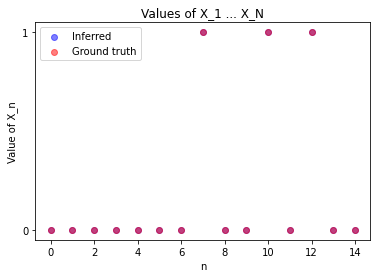

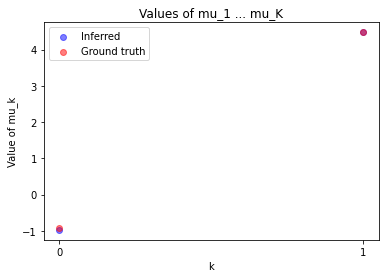

In [11]:
tail_len = num_samples // 10

xs_tail_plot = x_samples[-tail_len:].mean(0)
plt.scatter(
    range(len(xs_tail_plot)),
    xs_tail_plot,
    alpha=0.5,
    label="Inferred",
    c="b",
)
plt.scatter(
    range(len(xs_obs)), xs_obs, alpha=0.5, label="Ground truth", c="r"
)
plt.yticks(range(K))
plt.title("Values of X_1 ... X_N")
plt.xlabel("n")
plt.ylabel("Value of X_n")
plt.legend()
plt.show()

mus_tail_plot = mu_samples[-tail_len:].mean(0)
plt.scatter(range(K), mus_tail_plot, alpha=0.5, label="Inferred", c="b")
plt.scatter(range(K), mus_obs, alpha=0.5, label="Ground truth", c="r")
plt.xticks(range(K))
plt.title("Values of mu_1 ... mu_K")
plt.xlabel("k")
plt.ylabel("Value of mu_k")
plt.legend()
plt.show()


These plots indicate that inference seems to be recovering hidden states well, and is computing reasonably accurate values for $\mu$.

## Posterior likelihood checks

One way to evaluate posterior samples is computing likelihoods of our posterior samples, and comparing these to the likelihood of the underlying synthetic data. Formally, we can compute the joint likelihood of posterior samples with the observations used to generate the samples. And similarly, we can compute the joint likelihood of the observations with the underlying synthetic data which was generated at the same time as the observations.

In [12]:
def log_likelihood(xs, ys, thetas, mus, sigmas, N):
    """Returns the log likelihood of the HMM model conditioned on the data"""
    result = 0
    # transition probabilities
    for n in range(1, N):
        result += torch.log(thetas[xs[n - 1], xs[n]])
    # emission probabilities
    for n in range(N):
        result += dist.Normal(mus[xs[n]], sigmas[xs[n]]).log_prob(ys[n])
    return result


# computes the log likelihood of the HMM model per iteration
ppcs = [
    log_likelihood(x, y_obs, thetas_obs, mu, sigma, N)
    for x, mu, sigma in zip(x_samples.int(), mu_samples, sigma_samples)
]

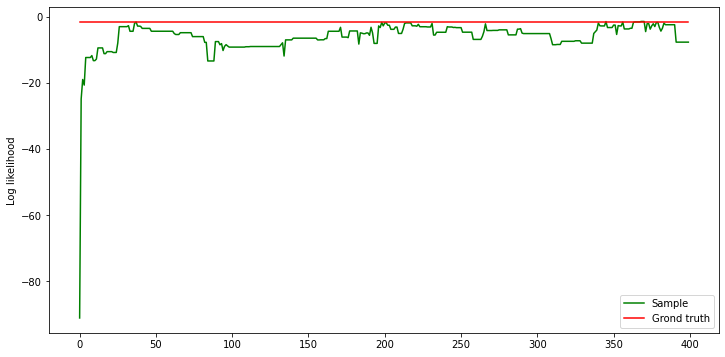

In [13]:
plt.figure(figsize=(12,6))
plt.plot(ppcs, label="Sample", c="g")
# plotting the ground truth for reference
plt.plot([log_likelihood(x_obs, y_obs, thetas_obs, mus_obs, sigmas_obs, N)] * num_samples, label="Grond truth", c="r")
plt.ylabel("Log likelihood")
plt.legend()
plt.show()

From the above plot, inference appears to be doing a good job of fitting the random variables given the observed data. Inference appears to converge with a log likelihood scores near to those generated by the ground truth parameters.